Import libraries

In [1]:
import pandas as pd
import numpy as np
import zipfile
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import glob
import random
import utilities_py as utilities

from skimage import io
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize

2024-02-22 07:05:58.094708: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 07:05:58.094819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 07:05:58.372753: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
brain_df = pd.read_csv('/kaggle/input/mri-ds/Brain_MRI/data_mask.csv')

In [3]:
brain_df.head()

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [4]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [5]:
brain_df.mask_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [6]:
brain_df.image_path[1] 

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

Data Visualization

In [7]:
brain_df

patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

In [8]:
brain_df['mask'].value_counts().index

Index([0, 1], dtype='int64', name='mask')

In [9]:
# Using plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

In [10]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [11]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

In [12]:
brain_df.mask_path[623]

'TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_6_mask.tif'

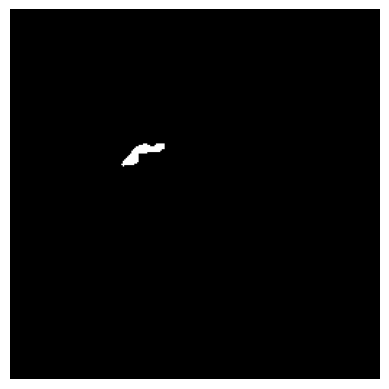

In [13]:
# Read the image
image_path = '/kaggle/input/mri-ds/Brain_MRI/{}'.format(brain_df.mask_path[623])
image = cv2.imread(image_path)

# Check if the image was read successfully
if image is not None:
    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print("Error: Unable to read the image file. Please check the file path and file integrity.")

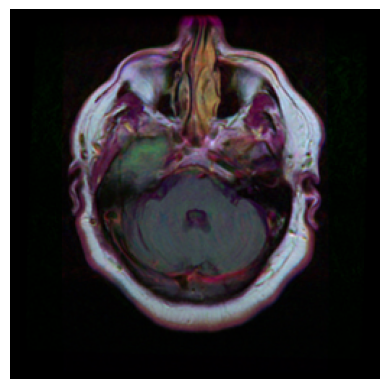

In [14]:
# Read the image
image_path = '/kaggle/input/mri-ds/Brain_MRI/{}'.format(brain_df.image_path[623])
image = cv2.imread(image_path)

# Check if the image was read successfully
if image is not None:
    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print("Error: Unable to read the image file. Please check the file path and file integrity.")

In [15]:
image_path = '/kaggle/input/mri-ds/Brain_MRI/{}'.format(brain_df.image_path[623])
cv2.imread(image_path).max()

253

In [16]:
image_path = '/kaggle/input/mri-ds/Brain_MRI/{}'.format(brain_df.image_path[623])
cv2.imread(image_path).min()

0

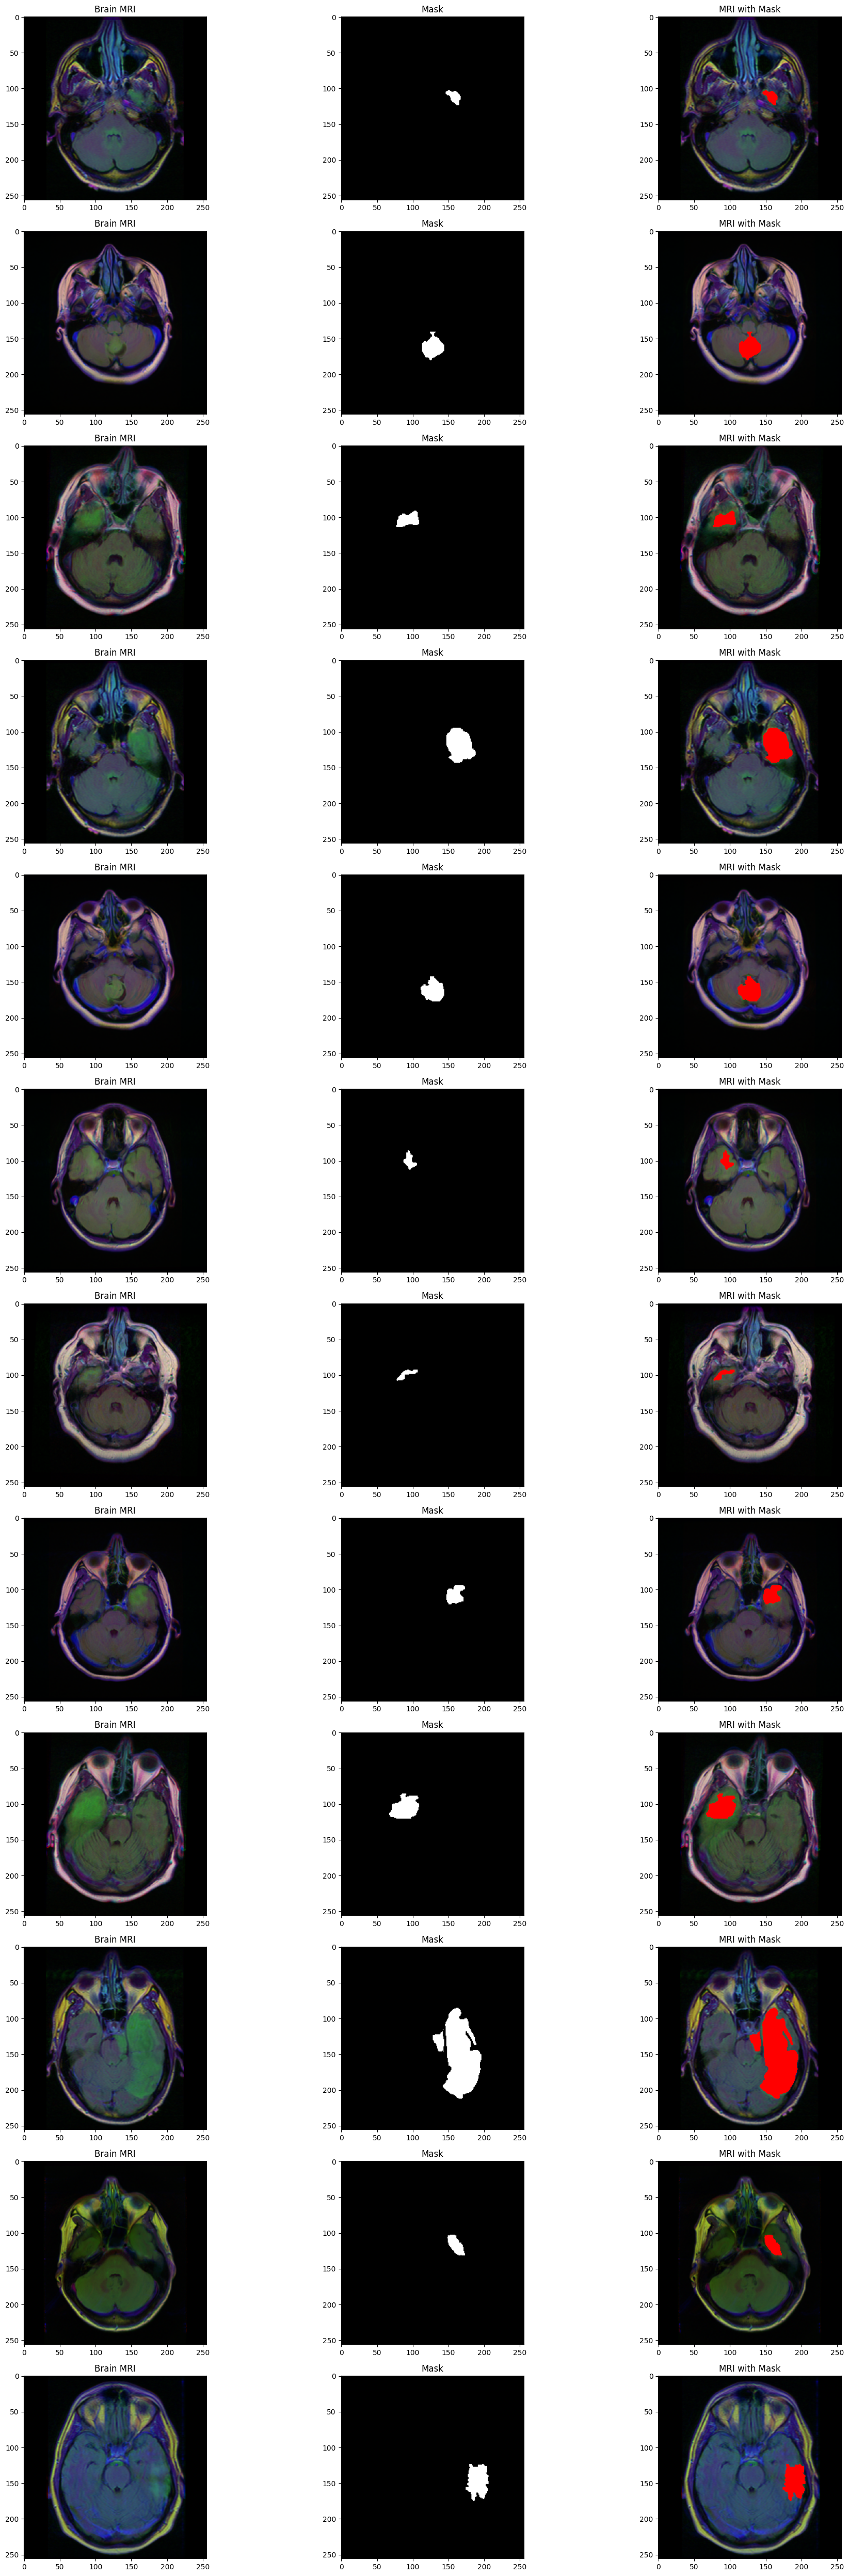

In [17]:
# Plotting 12 randomly selected (1) MRI scan images from only sick patients followed by (2) corresponding mask, (3) both MRI image and the corresponding mask (in red color) on top of each other
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img_p = '/kaggle/input/mri-ds/Brain_MRI/{}'.format(brain_df.image_path[i])
    mask_p = '/kaggle/input/mri-ds/Brain_MRI/{}'.format(brain_df.mask_path[i])
    
    img = io.imread(img_p)
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(mask_p)
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

Training a classifier to detect if tumor exists or not

In [18]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [19]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [20]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [21]:
# Split the data into train and test data
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df_train, test_size = 0.15)

In [22]:
# Creating a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., validation_split = 0.15)

In [23]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= '/kaggle/input/mri-ds/Brain_MRI/',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= '/kaggle/input/mri-ds/Brain_MRI/',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Creating a data generator for test images
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= '/kaggle/input/mri-ds/Brain_MRI/',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


ResNet50 base model

In [24]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94765736/94765736 [==============================] - 0s 0us/step


In [25]:
# basemodel.summary()

In [26]:
# Freezing model weights
for layer in basemodel.layers:
  layers.trainable = False

# Classification head to base model
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [27]:
# model.summary()

In [28]:
# # Compiling the model
# model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

# # use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
# earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# # save the best model with least validation loss
# checkpointer = ModelCheckpoint(filepath="/kaggle/input/classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [29]:
# history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

In [30]:
# # Saving the model architecture to json file for future use
# model_json = model.to_json()
# with open("classifier-resnet-model.json","w") as json_file:
#   json_file.write(model_json)

Evaluation of Model Performance

In [31]:
# Load pretrained model 
with open('/kaggle/input/mri-ds/Brain_MRI/resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('/kaggle/input/mri-ds/Brain_MRI/weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [32]:
# Prediction
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 10s 122ms/step


In [33]:
test_predict.shape

(576, 2)

In [34]:
test_predict

array([[1.4303543e-10, 1.0000000e+00],
       [2.1691123e-02, 9.7830886e-01],
       [9.9936026e-01, 6.3968590e-04],
       ...,
       [3.7223415e-04, 9.9962771e-01],
       [9.9938560e-01, 6.1439234e-04],
       [1.0000000e+00, 4.6970293e-19]], dtype=float32)

In [35]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [36]:
predict

array(['1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1',
       '0', '0', '1', '0', '1', '0', '1', '0', '0', '1', '0', '0', '1',
       '0', '1', '1', '1', '0', '1', '0', '1', '0', '0', '0', '0', '1',
       '0', '1', '1', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0',
       '1', '1', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1',
       '1', '0', '0', '0', '0', '1', '1', '1', '0', '0', '1', '1', '0',
       '1', '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', '0', '0',
       '1', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0',
       '1', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0',
       '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0',
       '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0

In [37]:
# Since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [38]:
# Accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9895833333333334

<Axes: >

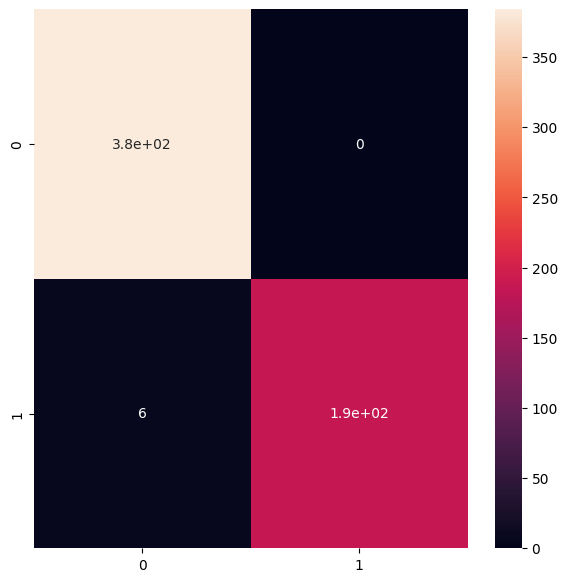

In [39]:
# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [40]:
# Classification
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       384
           1       1.00      0.97      0.98       192

   micro avg       0.99      0.99      0.99       576
   macro avg       0.99      0.98      0.99       576
weighted avg       0.99      0.99      0.99       576



Building a segmentation model to localize tumor

In [41]:
# Dataframe of MRIs associated with mask
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [42]:
# Split the data into train and test data
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [43]:
# Create separate list for imageId, classId to pass into the generator
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [44]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities_py import DataGenerator

# Create image generators
training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [45]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [46]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [47]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

Custom Loss Function:
Used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

@article{focal-unet, title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation}, author={Abraham, Nabila and Khan, Naimul Mefraz}, journal={arXiv preprint arXiv:1810.07842}, year={2018} }

Compiling the model

In [48]:
# from utilities_py import focal_tversky, tversky_loss, tversky

# # Compile the model
# adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
# model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

# # use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
# earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# # save the best model with lower validation loss
# checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [49]:
# history = model_seg.fit(training_generator, epochs = 1, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

In [50]:
# # Saving the model architecture for future use
# model_json = model_seg.to_json()
# with open("ResUNet-model.json","w") as json_file:
#   json_file.write(model_json)

Evaluation Model Performance

In [51]:
from utilities_py import focal_tversky, tversky_loss, tversky

with open('/kaggle/input/mri-ds/Brain_MRI/ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# Load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('/kaggle/input/mri-ds/Brain_MRI/weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [52]:
from utilities_py import prediction

# Making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

/kaggle/input/mri-ds/Brain_MRI/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_10.tif
1/1 [==============================] - 1s 1s/step
/kaggle/input/mri-ds/Brain_MRI/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_28.tif
1/1 [==============================] - 0s 23ms/step
/kaggle/input/mri-ds/Brain_MRI/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_18.tif
1/1 [==============================] - 0s 26ms/step
/kaggle/input/mri-ds/Brain_MRI/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_29.tif
1/1 [==============================] - 0s 22ms/step
/kaggle/input/mri-ds/Brain_MRI/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_7.tif
1/1 [==============================] - 0s 23ms/step
/kaggle/input/mri-ds/Brain_MRI/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_3.tif
1/1 [==============================] - 0s 24ms/step
/kaggle/input/mri-ds/Brain_MRI/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_10.tif
1/1 [==============================] - 0s 36ms/step
/kaggle/input/mri-ds/Brain_MRI/TCGA_HT_7475_19970918/TCGA_HT_7475_

In [53]:
# Creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_10...   
1    TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_28...   
2    TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_18...   
3    TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_29...   
4    TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_7.tif   
..                                                 ...   
585  TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_3.tif   
586  TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_16...   
587  TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_8.tif   
588  TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_19...   
589  TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_50...   

                                        predicted_mask  has_mask  
0    [[[[2.5874704e-06], [7.4313807e-06], [3.066481...         1  
1    [[[[7.386424e-07], [2.4937865e-06], [4.5959046...         1  
2                                              No mask         0  
3    [[[[6.748373e-07], [2.3534042e-06], [4.3315003...         1  
4                                              No mask         0  
..                                                 ...       ...  
585                                            No mask         0  
586                                            No mask         0  
587                                            No mask         0  
588                                            No mask         0  
589                                            No mask         0  

[590 rows x 3 columns]

In [54]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_10...   
1  TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_28...   
2  TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_18...   
3  TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_29...   
4  TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_7.tif   

                                           mask_path mask  \
0  TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_10...    1   
1  TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_28...    1   
2  TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_18...    0   
3  TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_29...    1   
4  TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_7_...    0   

                                      predicted_mask  has_mask  
0  [[[[2.5874704e-06], [7.4313807e-06], [3.066481...         1  
1  [[[[7.386424e-07], [2.4937865e-06], [4.5959046...         1  
2                                            No mask         0  
3  [[[[6.748373e-07], [2.3534042e-06], [4.3315003...         1  
4                                            No mask         0

Final Output

In [58]:
img_path = '/kaggle/input/mri-ds/Brain_MRI/{}'

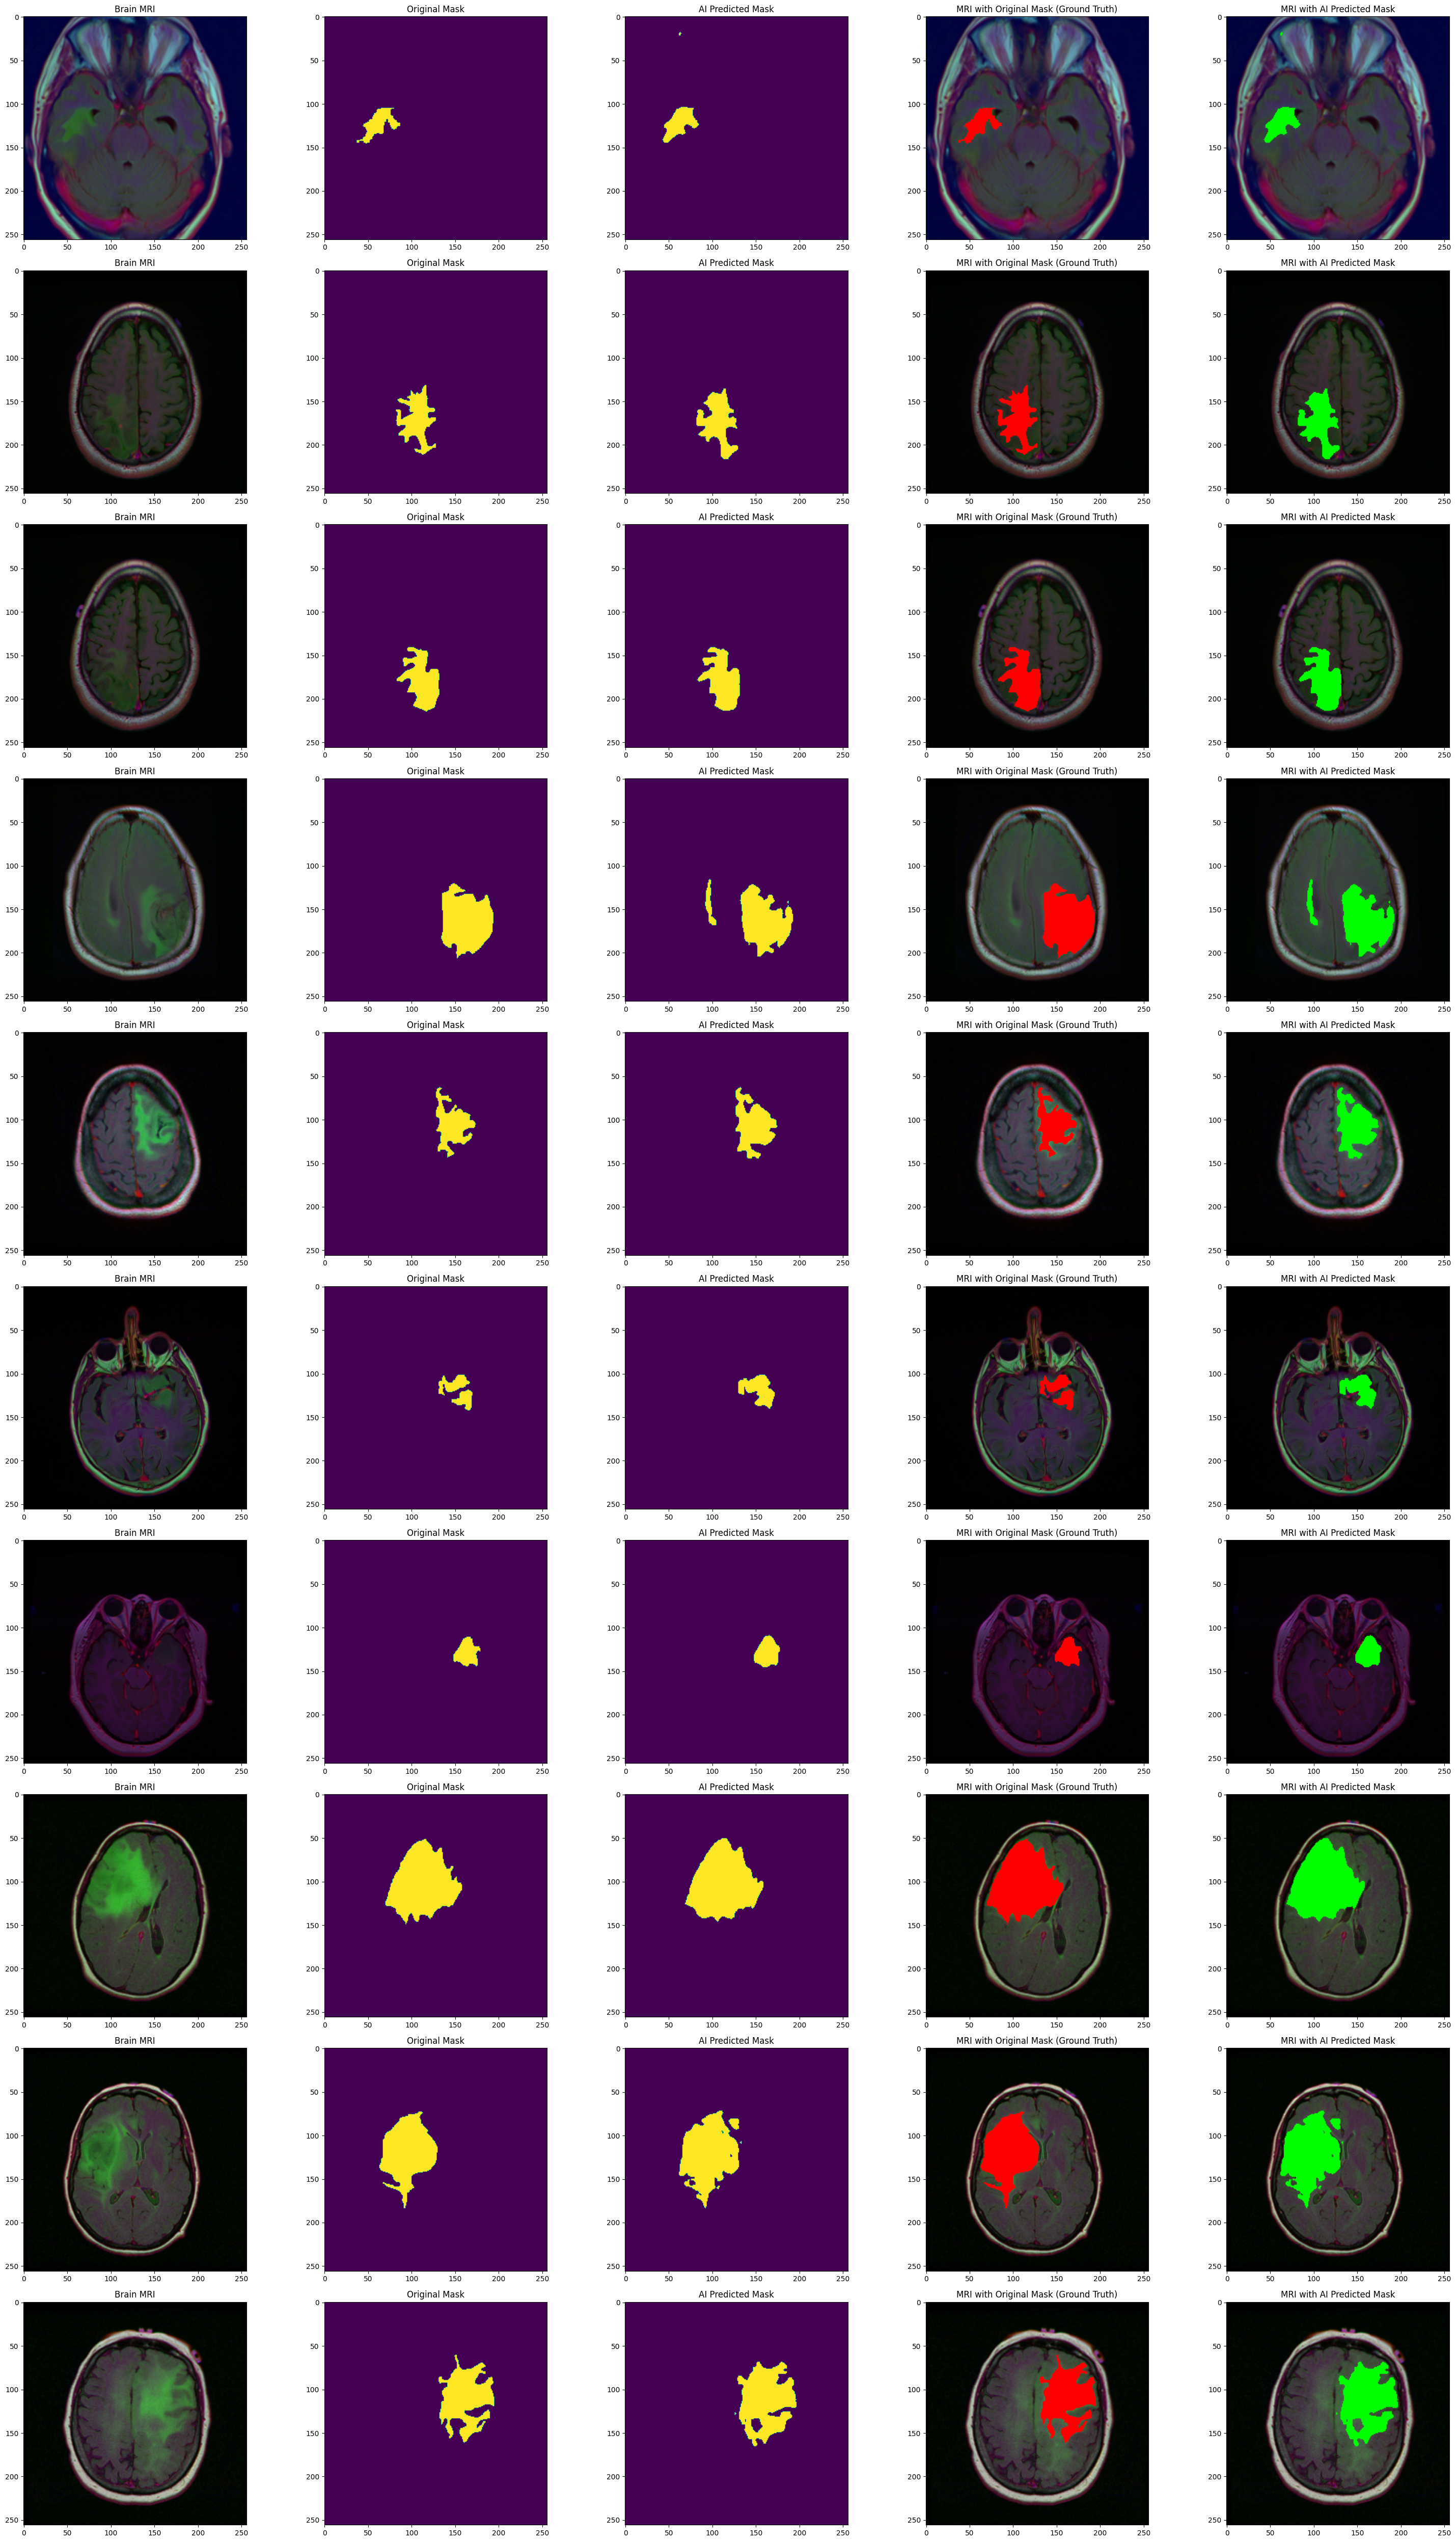

In [59]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(img_path.format(df_pred.image_path[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(img_path.format(df_pred.mask_path[i]))
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(img_path.format(df_pred.image_path[i]))
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()